## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('always', category=DeprecationWarning,
module=r'^{0}\.'.format(re.escape(__name__)))
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb

## Cleaning data

In [2]:
# Performs one-hot encoding on all non-numerical variables and also drops columns containing missing data:
def one_hot(data):
    bad_columns=[]
    for col in data.columns:
        if data[col].dtype=='object':
            bad_columns.append(col)
    return pd.get_dummies(data.dropna(),columns=bad_columns,drop_first=False)

def downsample(data,var_to_balance):
    vc=data[var_to_balance].value_counts()
    imin=vc.idxmin()
    result=data[data[var_to_balance]==imin]
    for i in vc.index:
        if i!=imin:
            result=pd.concat([result,data[data[var_to_balance]==i].sample(vc[imin])])
    return result
    
raw_data=pd.read_csv("anemia_neater.csv")
raw_data['mothers_education']=raw_data['mothers_education'].map({'No education':0,'Primary':1,'Secondary':2,'Higher':3})
raw_data['mothers_wealth_index']=raw_data['mothers_wealth_index'].map({'Poorest':0,'Poorer':1,'Middle':2,'Richer':3,'Richest':4})

# Replace mother's age group with the lowest boundary of respective age group (a useful numerical value):
clean_data=raw_data.assign(mothers_age_group = raw_data['mothers_age_group'].str[:2].astype(int),
                          child_tested = 1 - raw_data['childs_hemoglobin'].isna())



clean_data.replace({'Not anemic':0,'Mild':1,'Moderate':1,'Severe':1},inplace=True)
clean_data.replace('Yes',1,inplace=True)
clean_data.replace('No',0,inplace=True)
                                                                       
# A few "Don't know" values in the table; interpret as missing data:
clean_data.replace("Don't know",np.NaN,inplace=True)

anemia_data=downsample(one_hot(clean_data.drop(columns=['mothers_hemoglobin','childs_hemoglobin','child_tested'])),'childs_anemia')
anemia_data.shape

(5940, 17)

## Functions for analyzing results


In [3]:
# for binary 

def result(model, X, y, X_test, y_test):
    
    accuracy = model.score(X_test, y_test)
    print(f'accuracy: {accuracy:.4f}')
    
    y_probabilities = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_probabilities)
    print(f"AUC Score: {auc_score:.4f}")
    
def analyse_ROC(model,X_test,y_test,title='',steps=100,drawPicture=True,showCutoff=None):
    probabilities=pd.DataFrame(model.predict_proba(X_test))
    p=0
    dp=1/steps
    tpr_array=[]
    fpr_array=[]
    while p<=1:
        confusion=calculate_confusion(probabilities[1],y_test,p)
        tpr_array.append(confusion[0][0]/sum(confusion[0]))
        fpr_array.append(confusion[1][0]/sum(confusion[1]))
        p+=dp
    tpr_array=np.array(tpr_array)
    fpr_array=np.array(fpr_array)
    AUC=0
    for i in range(1,len(tpr_array)):
        AUC += (tpr_array[i-1]+tpr_array[i])/2 * (fpr_array[i-1]-fpr_array[i])
    # Add the area of the last corner (the calculated curve may not reach the (0,0) point):
    AUC += tpr_array[-1]/2 * fpr_array[-1]
    
    if drawPicture:
        plt.plot(fpr_array,tpr_array,label="{title}; AUC = {AUC:.3f}".format(title=title,AUC=AUC))
        if not (showCutoff is None):
            confusion=calculate_confusion(probabilities[1],y_test,showCutoff)
            plt.plot(confusion[1][0]/sum(confusion[1]),confusion[0][0]/sum(confusion[0]),'r+',markersize=8)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return AUC

def calculate_confusion(y_pred,y_test,threshold):
    df=pd.DataFrame({'p':y_pred, 'y':y_test.reset_index(drop=True)})
    df['predicted'] = (df['p']>=threshold)
    tots=len(df['predicted'])
    fp=(df['predicted']>df['y']).sum()
    fn=(df['predicted']<df['y']).sum()
    tp=df['predicted'].sum() - fp;
    tn = tots - fp - fn - tp;
    return ([[tp, fn], [fp, tn]])

     
                                    
# Trying other models
<br>


**Spliting the dataset onto train and test.**

In [4]:
X = anemia_data.drop(columns="childs_anemia")
y = anemia_data["childs_anemia"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

## RidgeClassifier

In [5]:
rid = RidgeClassifier(random_state=32)

In [6]:
rid.fit(X_train, y_train)

auc_score = roc_auc_score(y_test, rid.decision_function(X_test))

print('Accuracy: %f' % rid.score(X_test,y_test))
print('AUC Score: %f '% auc_score)

Accuracy: 0.603367
AUC Score: 0.635358 


**Hyperparameters tuning**

In [7]:
# param_grid_rid = {
#     'alpha':np.arange(0,5,0.1),
#     'solver':('auto', 'svdf', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs')
# }

param_grid_rid = {
    'alpha':[0],
    'solver':['auto']
}

gridsearch_rid = GridSearchCV(estimator=rid, param_grid=param_grid_rid, n_jobs=-1, 
                           cv=3, scoring='roc_auc',verbose=1)

gridsearch_rid.fit(X, y)

print(gridsearch_rid.best_params_)

#final output: {'alpha': 0.0, 'solver': 'auto'}


Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'alpha': 0, 'solver': 'auto'}


In [8]:
grid_auc_score = roc_auc_score(y_test, gridsearch_rid.decision_function(X_test))

print('Accuracy: %f' % gridsearch_rid.score(X_test,y_test))
print('AUC Score: %f '% grid_auc_score)

Accuracy: 0.646094
AUC Score: 0.646094 


## BaggingClassifier

In [9]:
bdt = BaggingClassifier(random_state=32)

In [10]:
bdt.fit(X_train, y_train)

result(bdt,X,y,X_test,y_test)

accuracy: 0.5576
AUC Score: 0.5613


**Hyperparameters tuning**

In [11]:
# param_grid_bdt = {
#     'n_estimators':np.arange(0,100)
# }

param_grid_bdt = {
    'n_estimators': [81]
}


gridsearch_bdt = GridSearchCV(estimator=bdt, param_grid=param_grid_bdt, n_jobs=-1, cv=3,
                           scoring='roc_auc',error_score=0,verbose=1)

gridsearch_bdt.fit(X_train, y_train)
print(gridsearch_bdt.best_params_,gridsearch_bdt.score(X_test,y_test))

#output: {'n_estimators': 81} 0.5963405472302774


Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'n_estimators': 81} 0.5802671549324401


accuracy: 0.5803
AUC Score: 0.5803


0.580219973651069

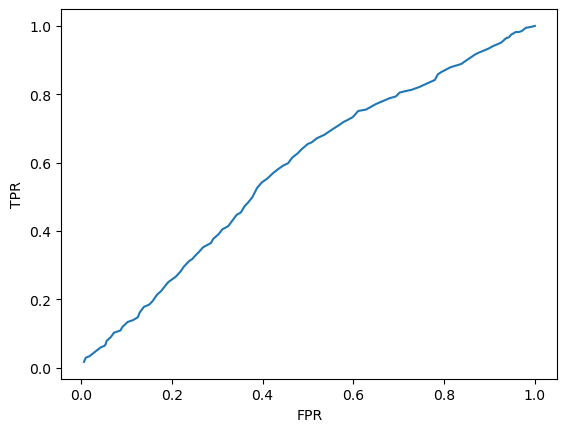

In [12]:
result(gridsearch_bdt,X,y,X_test,y_test)
analyse_ROC(gridsearch_bdt, X_test,y_test)

## XGBoost

In [13]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=32)

clf_xgb.fit(X_train,y_train,verbose=1,early_stopping_rounds=10,
            eval_metric='aucpr',eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.58511
[1]	validation_0-aucpr:0.59456
[2]	validation_0-aucpr:0.59095
[3]	validation_0-aucpr:0.59600
[4]	validation_0-aucpr:0.59162
[5]	validation_0-aucpr:0.59470
[6]	validation_0-aucpr:0.59548
[7]	validation_0-aucpr:0.59460
[8]	validation_0-aucpr:0.59146
[9]	validation_0-aucpr:0.59294
[10]	validation_0-aucpr:0.59025
[11]	validation_0-aucpr:0.58583
[12]	validation_0-aucpr:0.58518


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

**Hyperparameters tuning**

In [14]:
# space = {
#     'max_depth': np.arange(1,3),
#     'learning_rate': np.arange(0,10,0.5),
#     'gamma': np.arange(0,0.9,0.05),
#     'reg_lambda': np.arange(0,100,7),
#     'scale_pos_weight': np.arange(0,10)
# }

# randomsearch_xgb = RandomizedSearchCV(estimator=clf_xgb,param_distributions=space, n_iter=2000, 
#                                       scoring='roc_auc', n_jobs=-1, cv=3, random_state=32)

# randomsearch_xgb.fit(X_train,y_train)
# print(randomsearch_xgb.best_params_)

#final output:{'scale_pos_weight': 4, 'reg_lambda': 70, 'max_depth': 1, 'learning_rate': 0.5, 'gamma': 0.55}

In [15]:
# param_grid = {
#     'max_depth': [1,2],
#     'learning_rate': np.arange(0.50,0.0.58,0.02),
#     'gamma': np.arange(0.5,0.55,0.01),
#     'reg_lambda': np.arange(66,75),
#     'scale_pos_weight': np.arange(3.4,5.6,0.3)
# }

param_grid = {
    'max_depth': [1],
    'learning_rate': [0.5],
    'gamma': [0.54],
    'reg_lambda': [67],
    'scale_pos_weight': [4]
}


optimal_params = GridSearchCV(estimator=clf_xgb, n_jobs = -1, param_grid=param_grid, scoring='roc_auc', 
                              verbose=1, cv=3)
optimal_params.fit(X_train,y_train)

print(optimal_params.best_params_)

#final output:{'gamma': 0.54, 'learning_rate': 0.5, 'max_depth': 1, 'reg_lambda': 67, 'scale_pos_weight': 4}



Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'gamma': 0.54, 'learning_rate': 0.5, 'max_depth': 1, 'reg_lambda': 67, 'scale_pos_weight': 4}


In [16]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.5, max_depth=1, gamma=0.54,
                            reg_lambda=67, scale_pos_weight=4,seed=32)


clf_xgb.fit(X_train,y_train,verbose=1,early_stopping_rounds=10,
            eval_metric='aucpr',eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.51018
[1]	validation_0-aucpr:0.55165
[2]	validation_0-aucpr:0.59057
[3]	validation_0-aucpr:0.59154
[4]	validation_0-aucpr:0.60289
[5]	validation_0-aucpr:0.60302
[6]	validation_0-aucpr:0.60310
[7]	validation_0-aucpr:0.60267
[8]	validation_0-aucpr:0.60291
[9]	validation_0-aucpr:0.59956
[10]	validation_0-aucpr:0.60292
[11]	validation_0-aucpr:0.60190
[12]	validation_0-aucpr:0.60044
[13]	validation_0-aucpr:0.60021
[14]	validation_0-aucpr:0.60226
[15]	validation_0-aucpr:0.60170
[16]	validation_0-aucpr:0.60329
[17]	validation_0-aucpr:0.60352
[18]	validation_0-aucpr:0.60368
[19]	validation_0-aucpr:0.60371
[20]	validation_0-aucpr:0.60306
[21]	validation_0-aucpr:0.60283
[22]	validation_0-aucpr:0.60311
[23]	validation_0-aucpr:0.60348
[24]	validation_0-aucpr:0.60367
[25]	validation_0-aucpr:0.60369
[26]	validation_0-aucpr:0.60364
[27]	validation_0-aucpr:0.60376
[28]	validation_0-aucpr:0.60503
[29]	validation_0-aucpr:0.60513
[30]	validation_0-aucpr:0.60522
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.54, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

**Hyperparameters tuning has not increased XGBClassifier auc result much**

##### Best decision tree based on the result of XGBClassifier

weight:  {'mothers_education': 1.0}
gain:  {'mothers_education': 94.0830078125}
cover:  {'mothers_education': 2796.0}
total_gain:  {'mothers_education': 94.0830078125}
total_cover:  {'mothers_education': 2796.0}


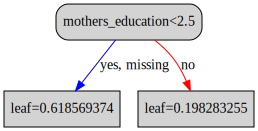

In [17]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.5, max_depth=1, gamma=0.54,
                            reg_lambda=67, scale_pos_weight=4,seed=32,n_estimators=1)
clf_xgb.fit(X_train,y_train)

best_tree=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, best_tree.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
              'style': 'filled, rounded'}
leaf_params = {'shape': 'box',
              'style': 'filled'}

xgb.to_graphviz(clf_xgb, num_trees=0, size='10,10', condition_node_params=node_params,
                leaf_node_params=leaf_params)
